# 🔮 전처리 CV 연구하기

In [111]:
import os
import glob
from typing import Callable, List

import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

In [13]:
class path:
    img_root = "./images"
    highlight = f"{img_root}/highlight"
    resolution = f"{img_root}/row_resolution"
    background = f"{img_root}/background"
    brightness = f"{img_root}/brightness"

## 1. 이미지 카테고리 확인하기

In [7]:
os.listdir(path.img_root)

['background', 'brightness', 'highlight', 'row_resolution']

- `background` : 뒷 배경에 공책선, 격자 등 수식 외에 배경이 있는 경우
- `brightness` : 전체적으로 너무 어둡거나 밟거나 혹은 부분적으로 밝기가 다른 경우
- `hightlight` : 형광펜이 있는 경우
- `row_resolution` : 해상도가 낮거나 흔들림이 있어서 글씨가 안 보이는 경우

## 2. 각 카테고리 별 이미지 확인하기

In [112]:
def show_images(img_dir:str, fig_size:tuple=(20, 12), divider:int=4)->None:
    img_paths = os.listdir(img_dir)
    len_of_img = len(img_paths)
    
    fig = plt.figure(figsize=fig_size)
    nrow, ncol = len_of_img//divider+1, divider
    for i, img_path in enumerate(img_paths):
        img = cv.imread(f"{img_dir}/{img_path}")
        ax = fig.add_subplot(nrow, ncol, i+1)
        ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        ax.set_title(img_path, fontsize=16)
        ax.axis("off")
    
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    plt.show()

### 2.1. highlight

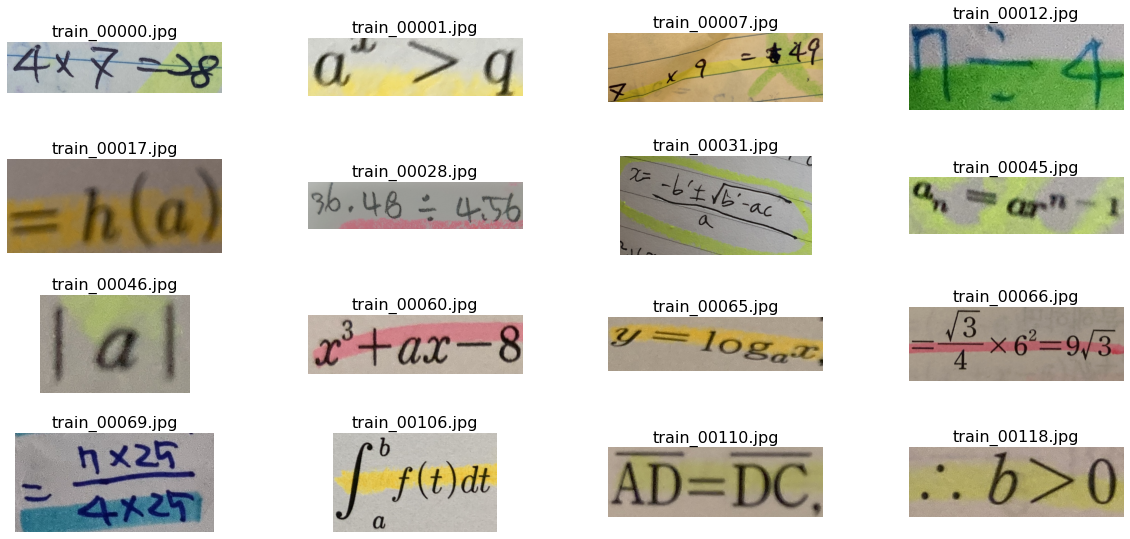

In [113]:
show_images(path.highlight)

### 2.2. row resolution

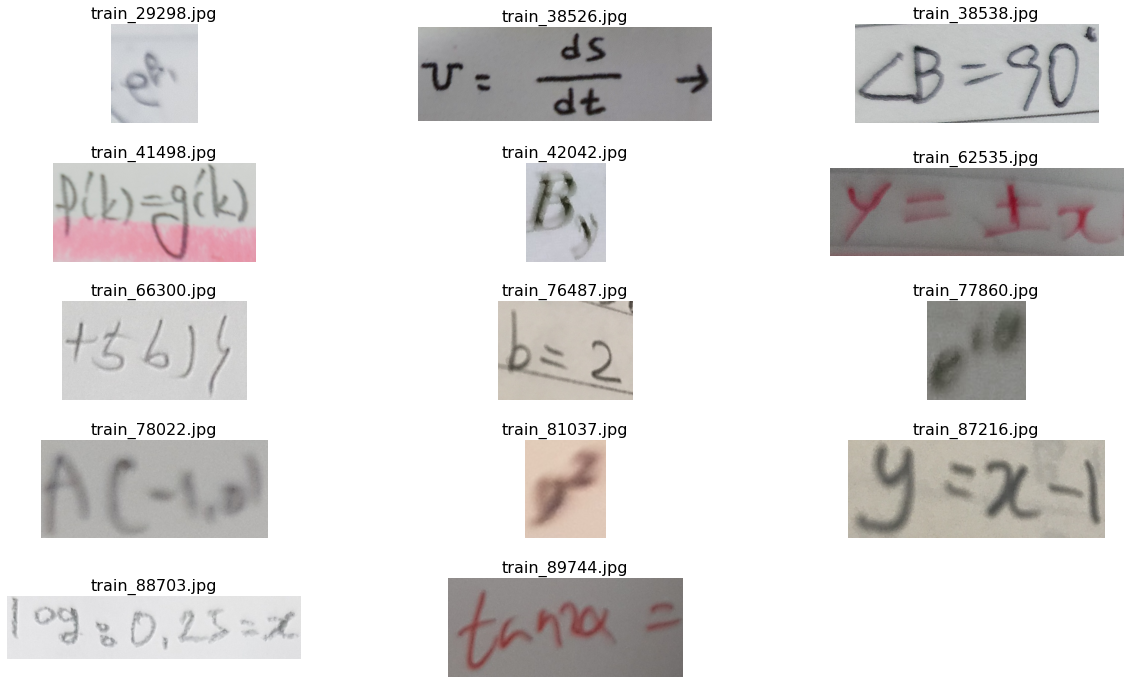

In [114]:
show_images(path.resolution, divider=3)

### 2.3. background

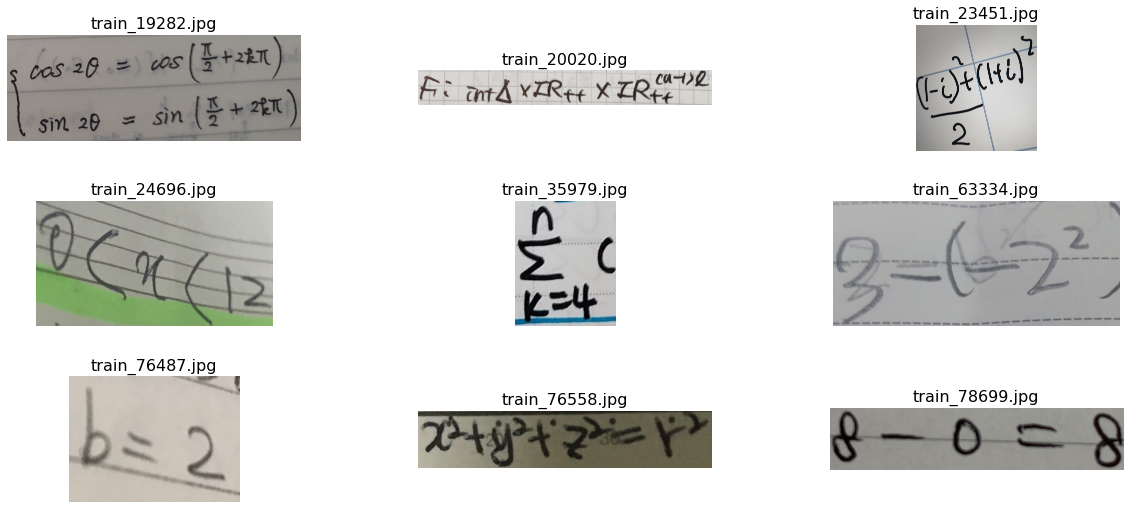

In [115]:
show_images(path.background, divider=3)

### 2.4. brightness

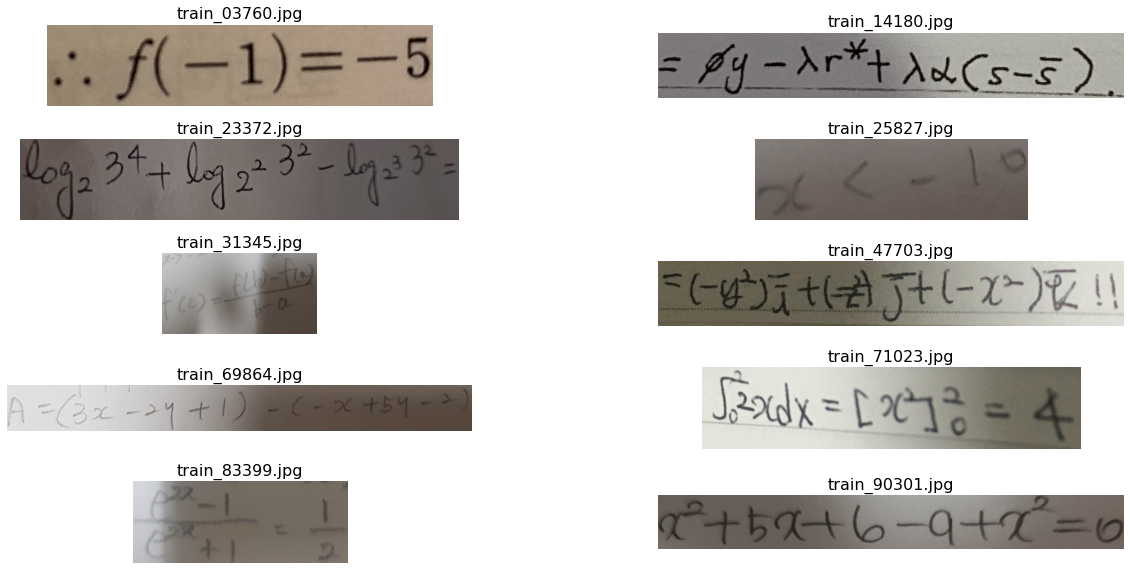

In [116]:
show_images(path.brightness, divider=2)

## 3. CV 함수 정의하기

### 3.1. 이미지 로드

In [265]:
def load_images(img_dir:str)->List:
    img_paths = os.listdir(img_dir)
    imgs = []
    for i, img_path in enumerate(img_paths):
        img = cv.imread(f"{img_dir}/{img_path}")
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        imgs.append(img)
    return imgs

### 3.2. 이미지 출력

In [336]:
def show_transformed_images(imgs:List, img_paths:List, fig_size:tuple=(20, 12), divider:int=4, transform:Callable=None, args=None)->np.ndarray:
    len_of_img = len(imgs)
    new_imgs = []
    
    fig = plt.figure(figsize=fig_size)
    nrow, ncol = len_of_img//divider+1, divider
    for i, (img, img_path) in enumerate(zip(imgs, img_paths)):
        if args:
            img, cfg = transform(img, **args)
        else:
            img, cfg = transform(img)
        new_imgs.append(img)
        
        ax = fig.add_subplot(nrow, ncol, i+1)
        if cfg:
            ax.imshow(img, **cfg)
        else:
            ax.imshow(img)
        ax.set_title(img_path, fontsize=16)
        ax.axis("off")
    
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    plt.show()
    
    return new_imgs

### 3.3. CV 함수 몇 가지

In [267]:
# rgb에서 grayscale로 변환
def rgb_to_gray(img:np.ndarray)->np.ndarray:
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    cfg = {"cmap": "gray"}
    return img, cfg

In [307]:
# 모폴로지 침식
def morph_ellipse(img:np.ndarray)->np.ndarray:
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (4, 4), anchor=(-1, -1))
    img = cv.erode(img, kernel, iterations=3)
    cfg = {'cmap':'gray'}
    return img, cfg

In [269]:
# 정규화
def normalize(img:np.ndarray)->np.ndarray:
    img = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX)
    cfg = {'cmap':'gray'}
    return img, cfg

In [317]:
# 오츠 알고리즘
def threshold(img:np.ndarray, adaptive:bool=False)->np.ndarray:
    if not adaptive:
        thres, img = cv.threshold(img, 127, 255, cv.THRESH_TRUNC)
    # adaptive threshold
    else:
        thres, img = cv.threshold(img, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
        img = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 9, 5)
    cfg = {'cmap':'gray'}
    return img, cfg

In [271]:
# clahe 변환
def clahe(img:np.ndarray)->np.ndarray:
    img = cv.cvtColor(img, cv.cv2.COLOR_BGR2YUV)
    cl = cv.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    img[:,:,0] = cl.apply(img[:,:,0])
    img = cv.cvtColor(img, cv.COLOR_YUV2BGR)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    cfg = {'cmap':'gray'}
    return img, cfg

In [362]:
# 평탄화
def equalize(img:np.ndarray)->np.ndarray:
    img = cv.equalizeHist(img)
    cfg = {'cmap':'gray'}
    return img, cfg

## 4. 각 카테고리별 CV 찾기

### 4.1. highlight
- 흑백 이미지로 변환해서 형광펜의 색을 없애 모델이 형광펜을 형광펜이라 인식하지 못하게 해야한다.
- 형광펜의 경우 색이 있기 때문에 눈에 띄지만 색을 제외하고는 투명한 막을 씌운 것과 같기 때문에 평균 픽셀값을 넘지 못했을 경우 픽셀을 제외시키면 될 것 같다.

#### 원본 이미지

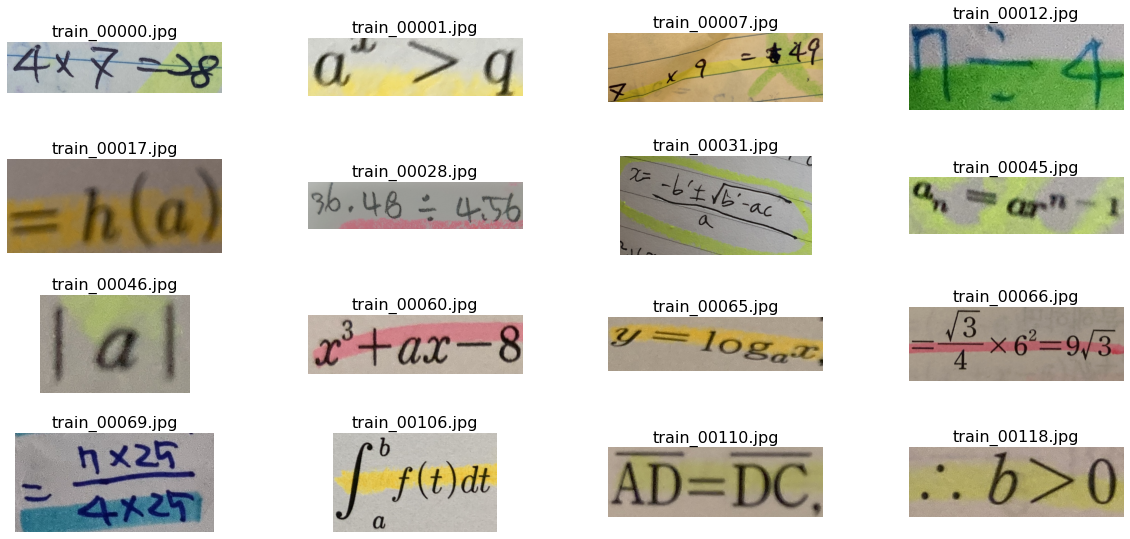

In [308]:
show_images(path.highlight)

#### 흑백 이미지로 변환

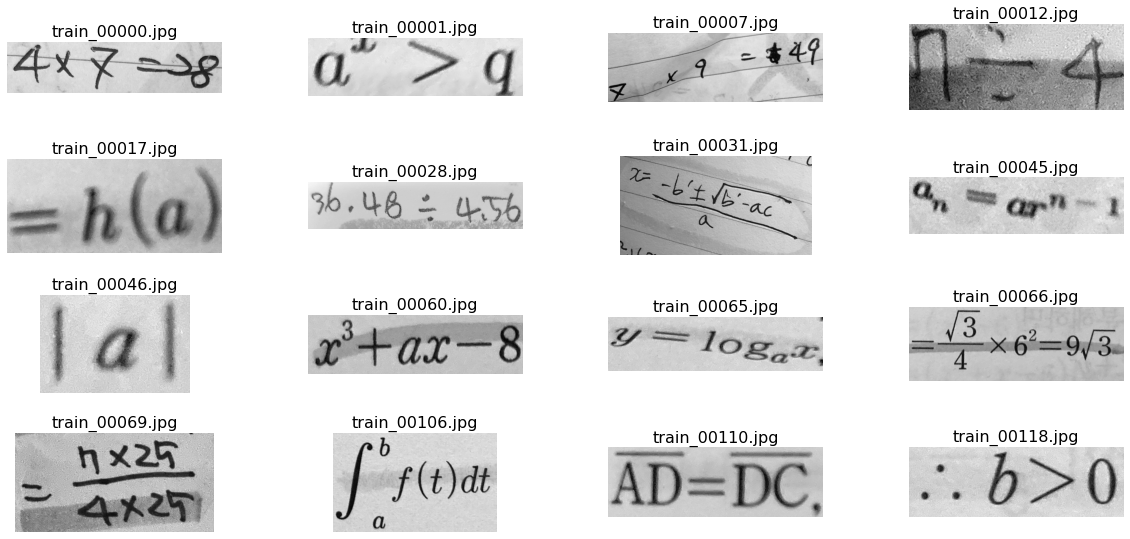

In [309]:
# 이미지 불러오기
highlight_imgs = load_images(path.highlight)
img_paths = os.listdir(path.highlight)
highlight_imgs = show_transformed_images(highlight_imgs, img_paths, transform=rgb_to_gray)

#### 정규화

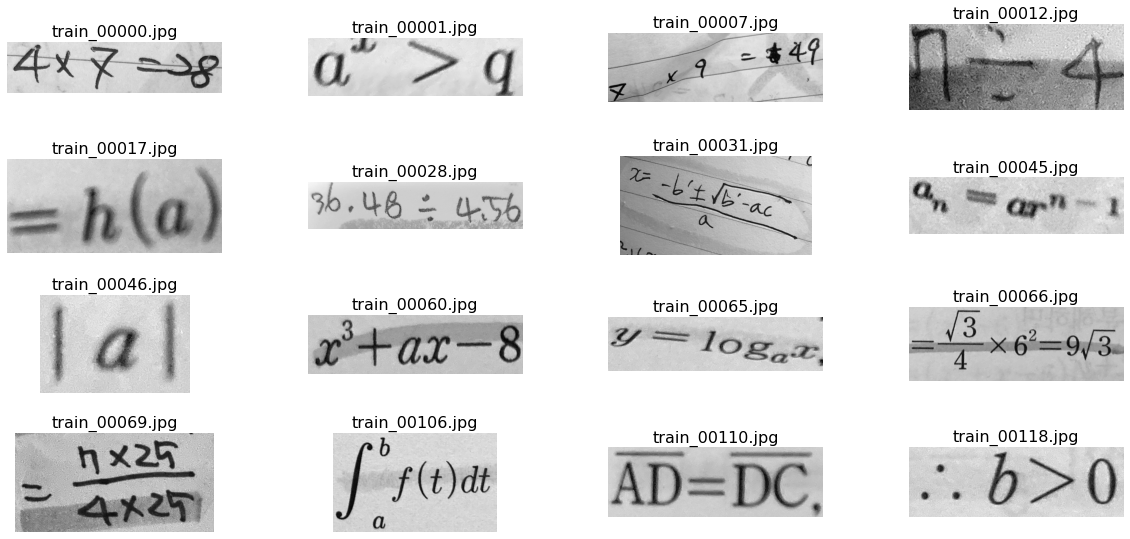

In [310]:
highlight_imgs = show_transformed_images(highlight_imgs, img_paths, transform=normalize)

#### 모폴로지 침식

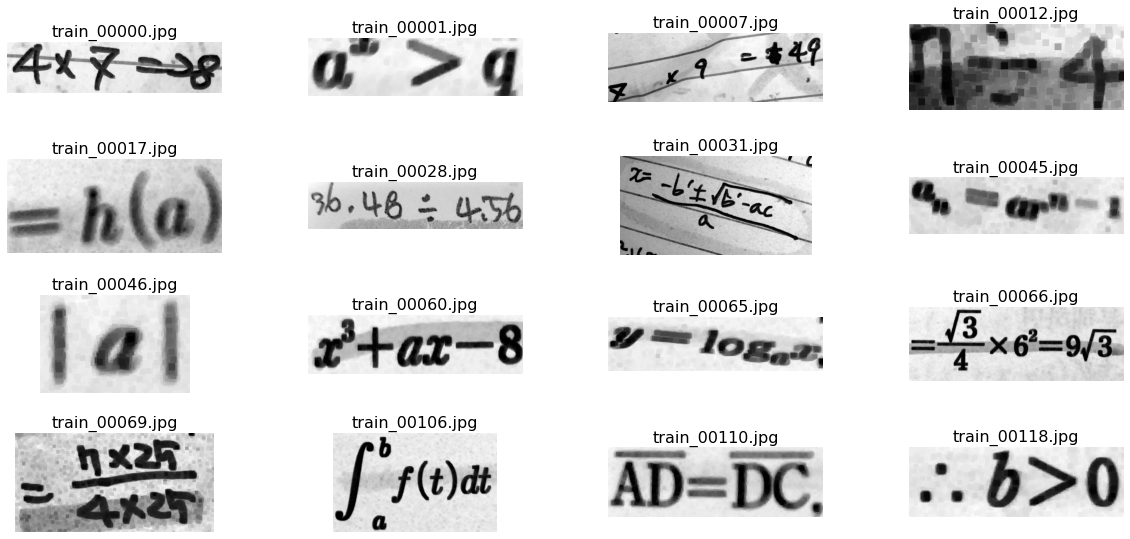

In [311]:
highlight_imgs = show_transformed_images(highlight_imgs, img_paths, transform=morph_ellipse)

#### 오츠 알고리즘

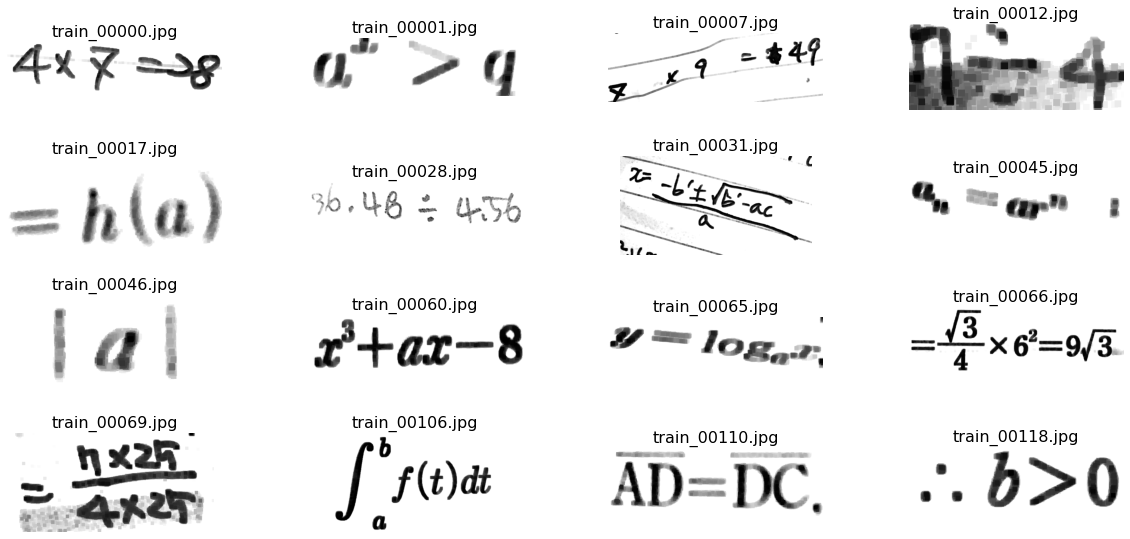

In [312]:
highlight_imgs = show_transformed_images(highlight_imgs, img_paths, transform=threshold)

### 4.2. row resolution
- 선명하지 않기 때문에 선명하게 만들어야 한다.
- 명도가 다 달라서 정규화는 필수인 듯.

#### 원본 이미지

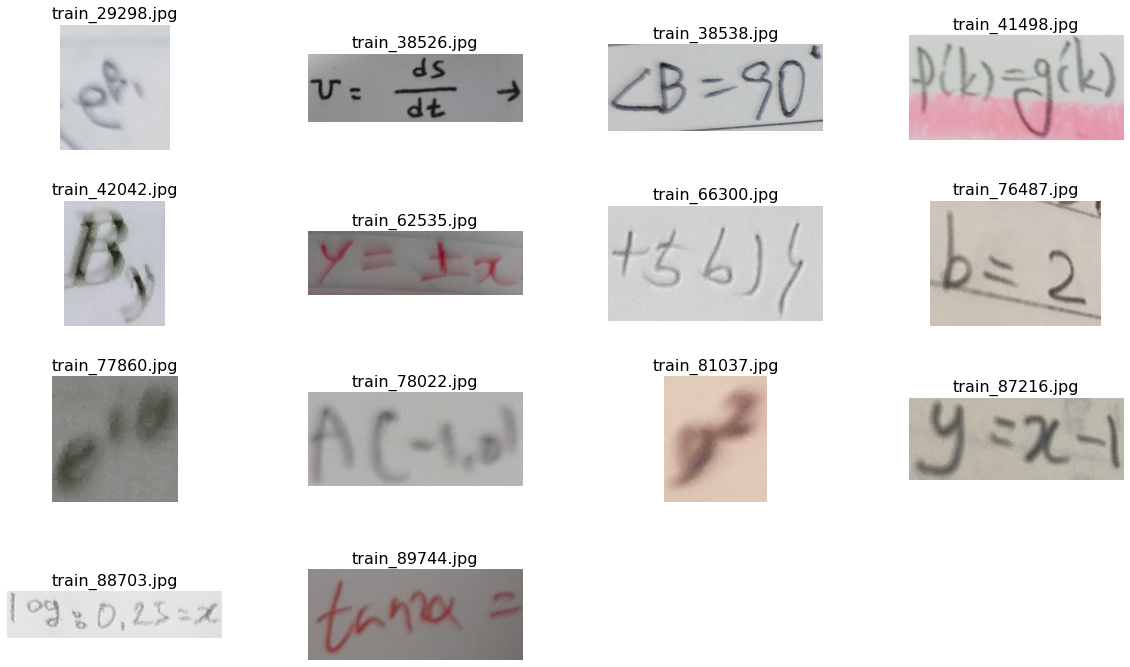

In [313]:
show_images(path.resolution)

#### 흑백 이미지로 변환

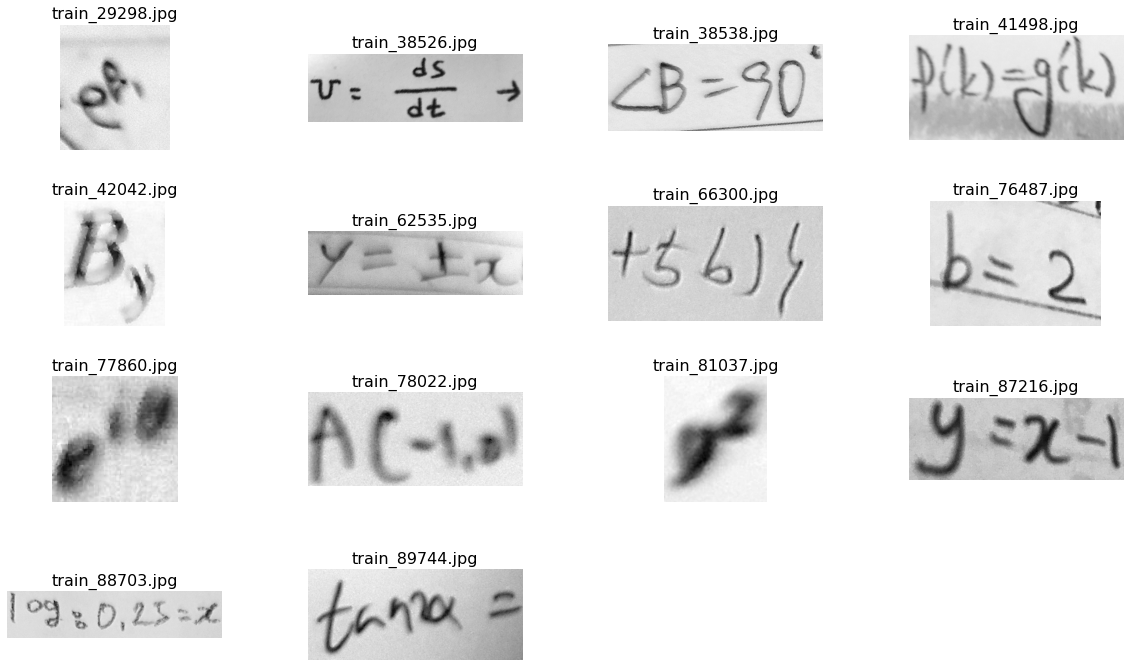

In [328]:
# 이미지 불러오기
resolution_imgs = load_images(path.resolution)
img_paths = os.listdir(path.resolution)
resolution_imgs = show_transformed_images(resolution_imgs, img_paths, transform=rgb_to_gray)

#### 정규화

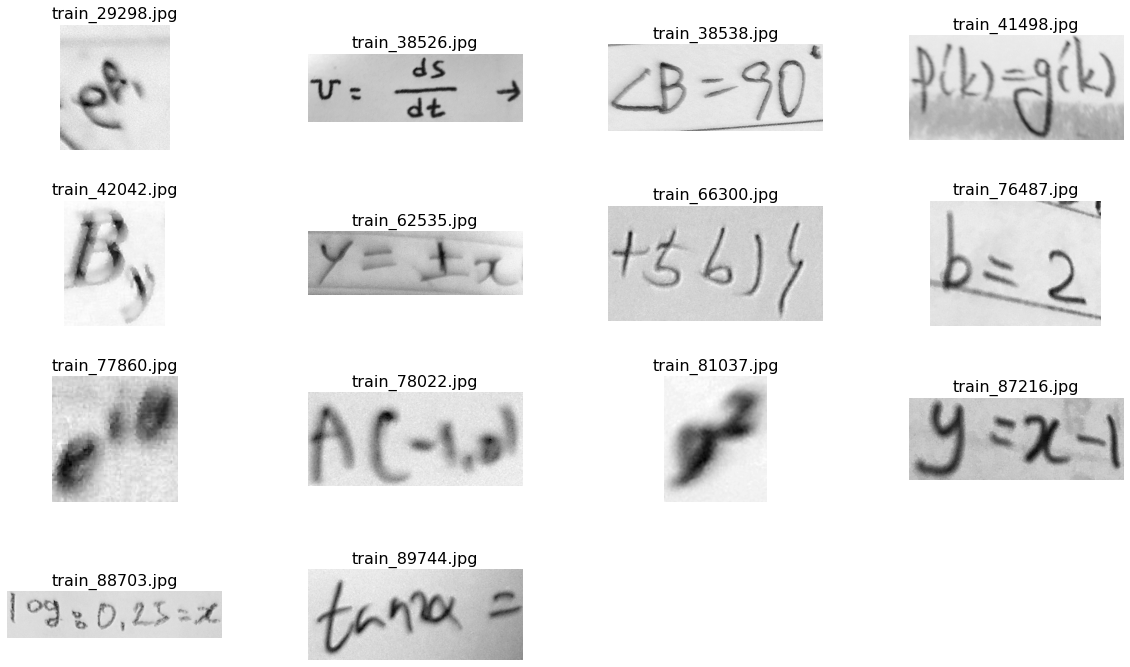

In [329]:
resolution_imgs = show_transformed_images(resolution_imgs, img_paths, transform=normalize)

#### 모폴로지 침식

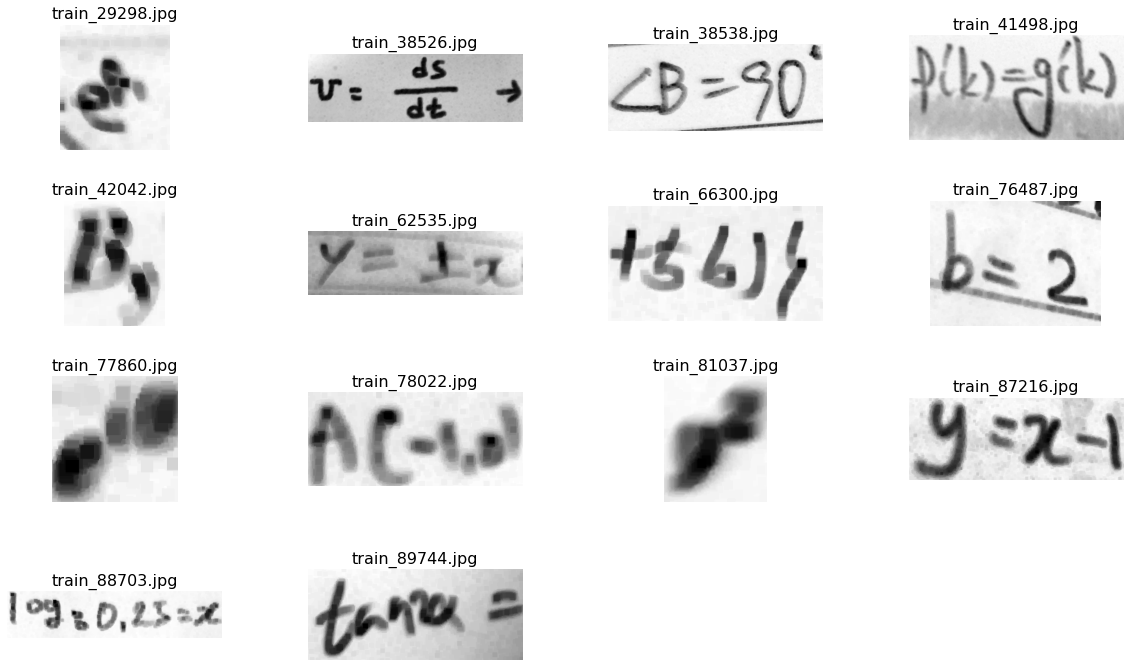

In [330]:
resolution_imgs = show_transformed_images(resolution_imgs, img_paths, transform=morph_ellipse)

### 3.3. background
- 오츠 알고리즘으로 어느 정도 제거 가능.
- 그 전에 모폴로지 침식으로 필요없는 노이즈 제거하자.

#### 원본 이미지

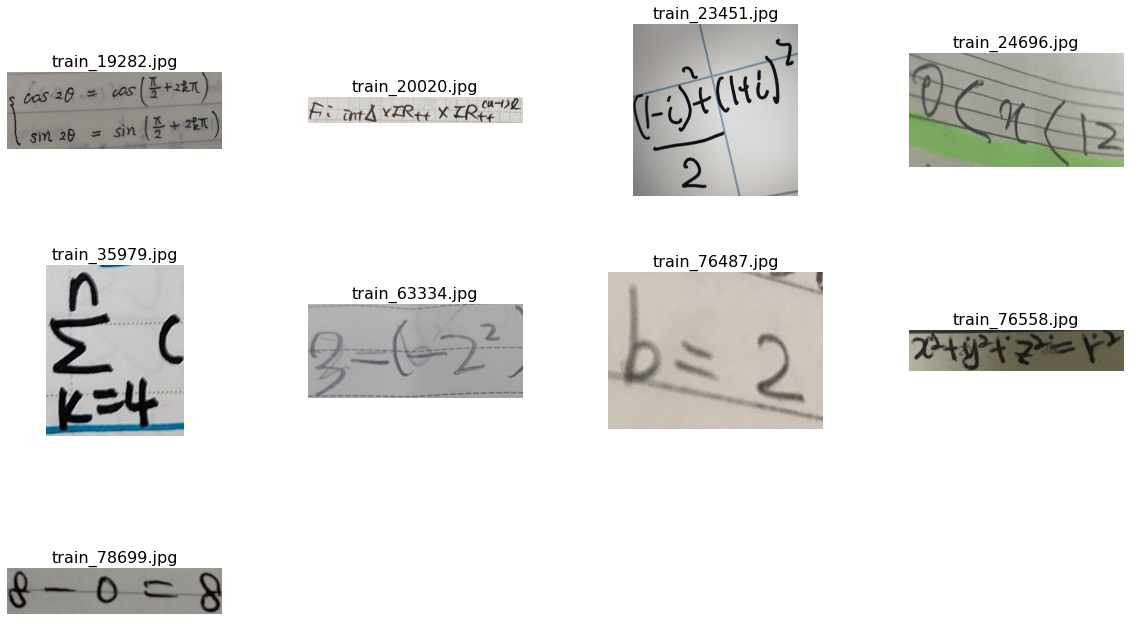

In [318]:
show_images(path.background)

#### 흑백 이미지로 변환

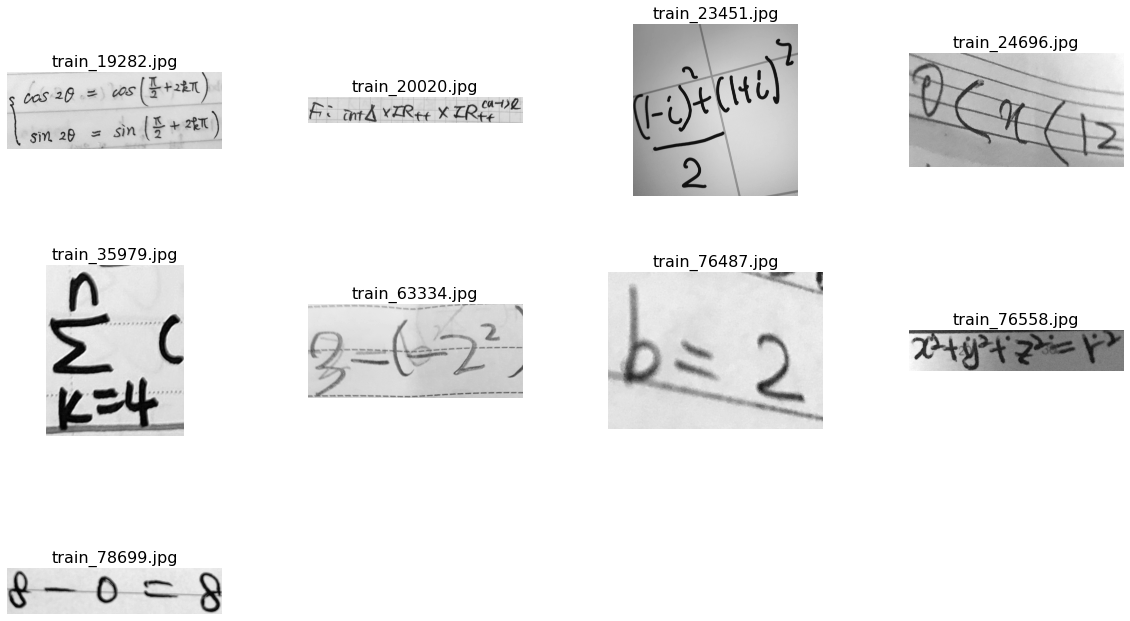

In [352]:
# 이미지 불러오기
background_imgs = load_images(path.background)
img_paths = os.listdir(path.background)
background_imgs = show_transformed_images(background_imgs, img_paths, transform=rgb_to_gray)

#### 정규화

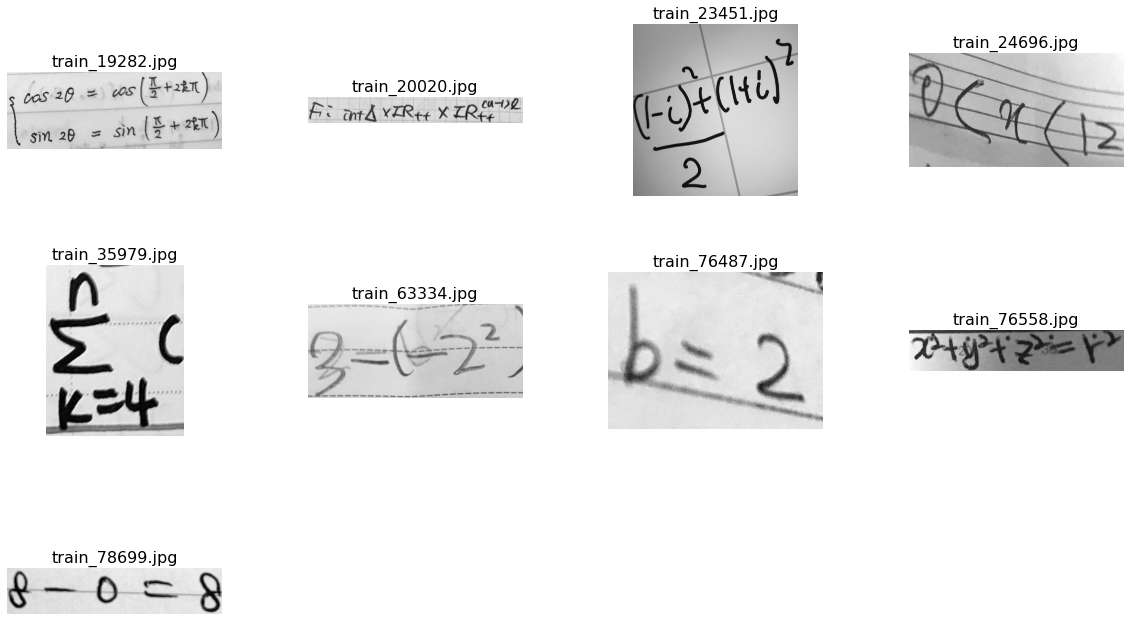

In [353]:
background_imgs = show_transformed_images(background_imgs, img_paths, transform=normalize)

#### 모폴로지 침식

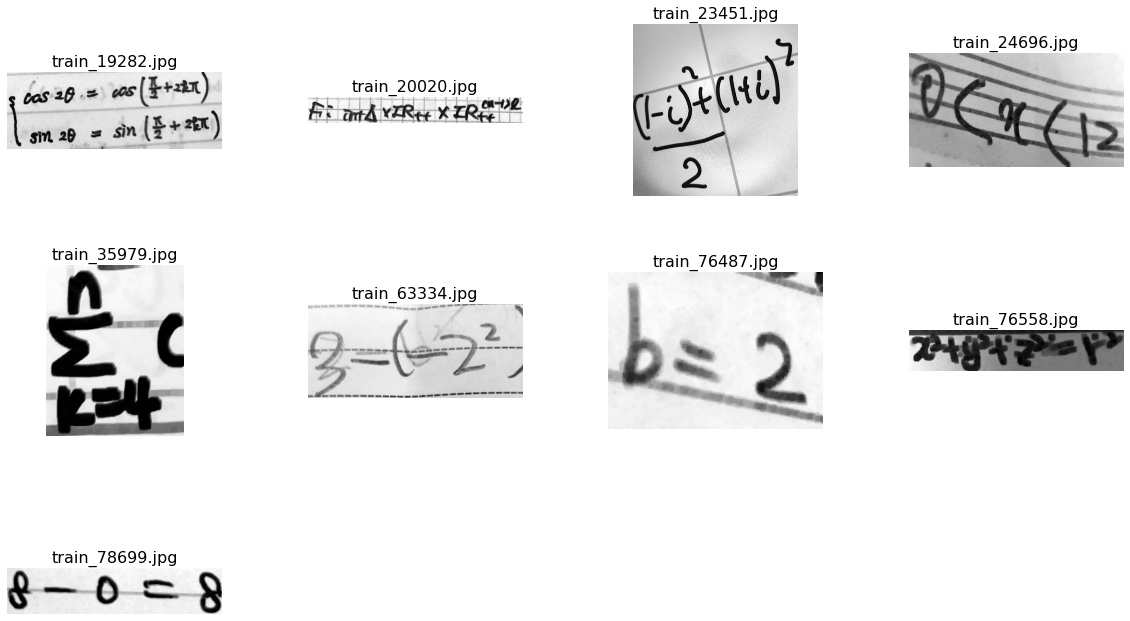

In [354]:
background_imgs = show_transformed_images(background_imgs, img_paths, transform=morph_ellipse)

#### 오츠 알고리즘

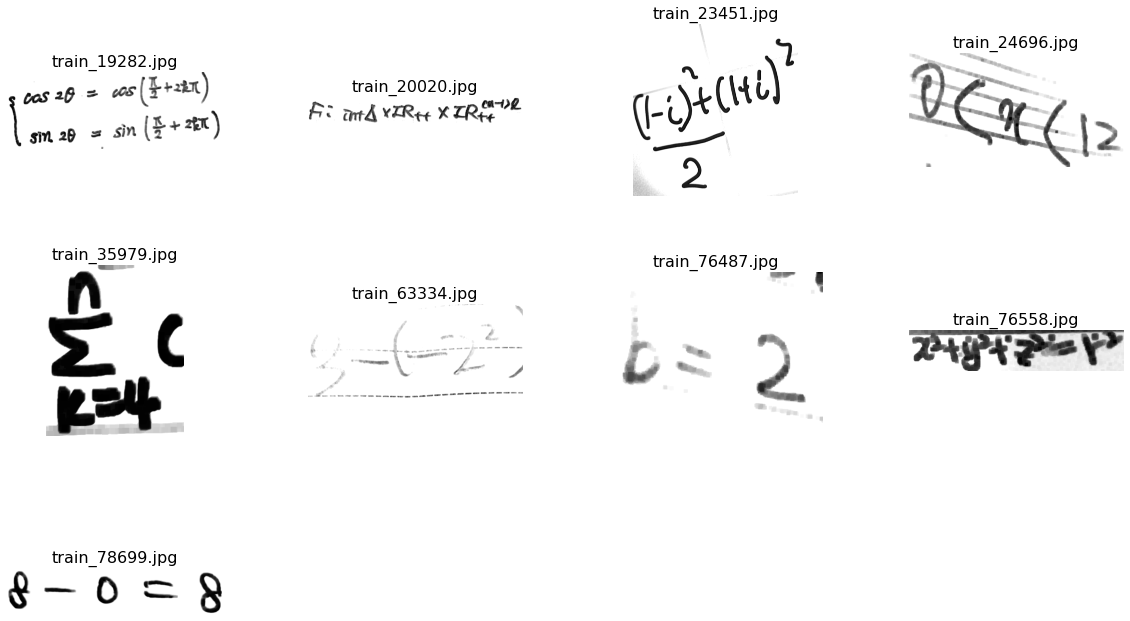

In [355]:
args = {"adaptive": False}
background_imgs = show_transformed_images(background_imgs, img_paths, transform=threshold, args=args)

### 3.4. brightness

#### 원본 이미지

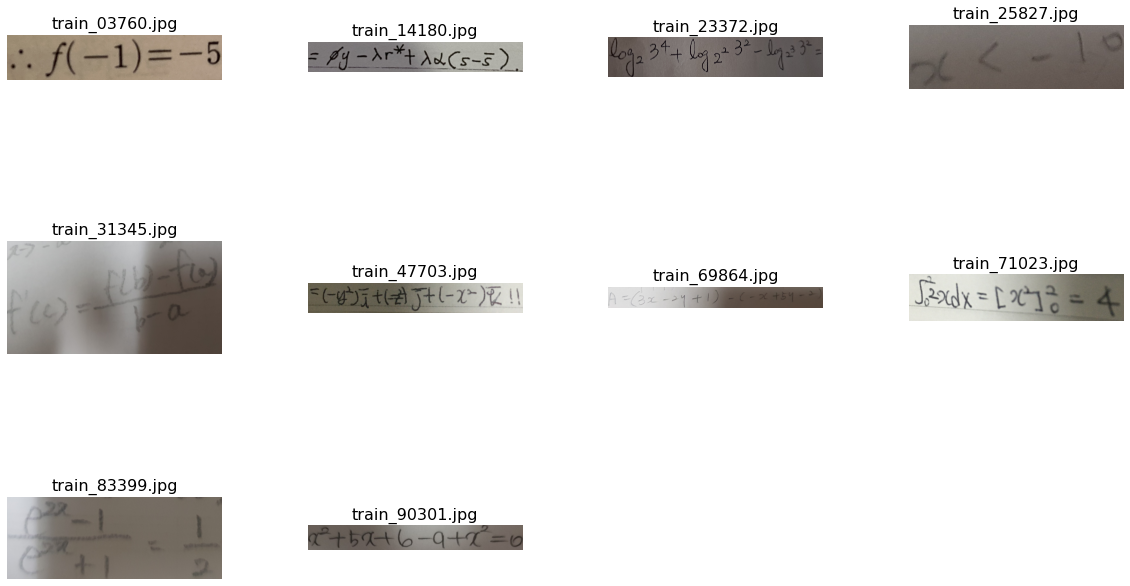

In [356]:
show_images(path.brightness)

#### CLAHE

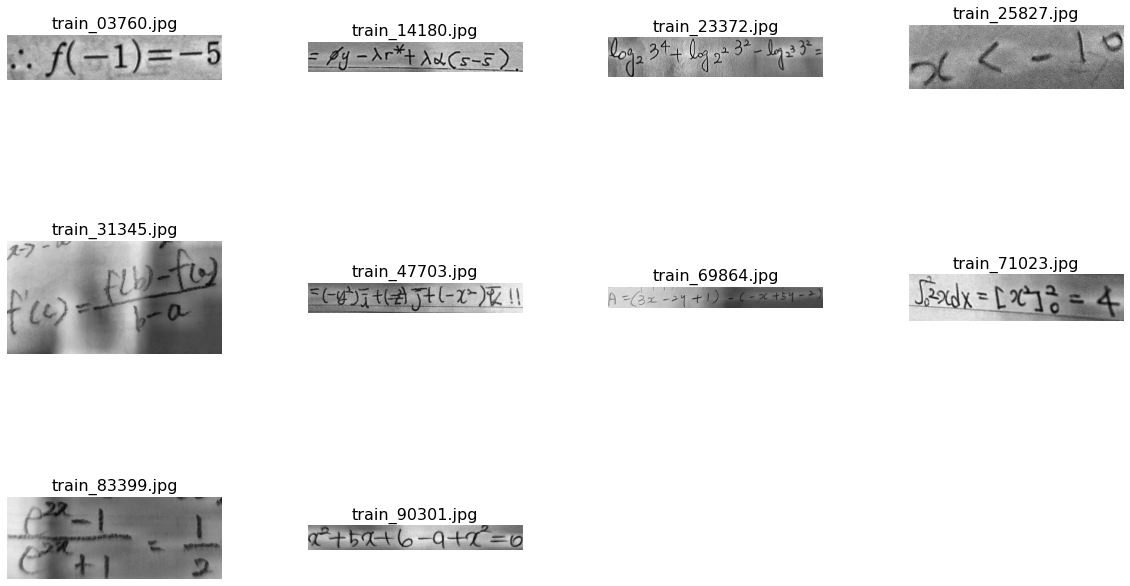

In [361]:
# 이미지 불러오기
brightness_imgs = load_images(path.brightness)
img_paths = os.listdir(path.brightness)
brightness_imgs = show_transformed_images(brightness_imgs, img_paths, transform=clahe)

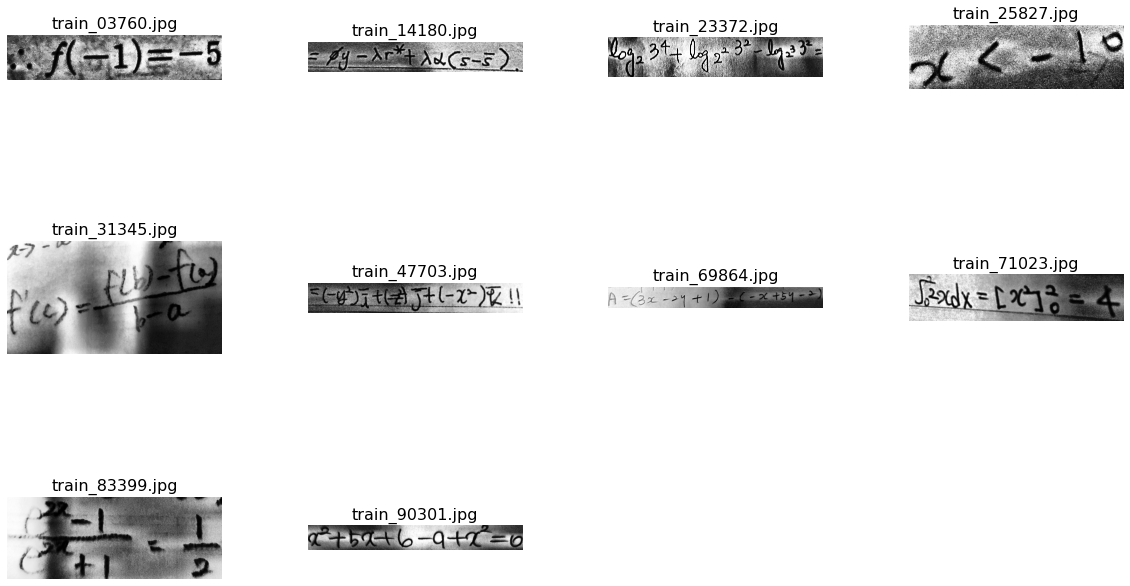

In [363]:
brightness_imgs = show_transformed_images(brightness_imgs, img_paths, transform=equalize)